In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from scipy.interpolate import LSQUnivariateSpline

In [2]:
#Problem 1

In [5]:
#a

In [3]:
data = pd.read_csv("strongdrink.txt")
data.describe()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,1.926136,13.006534,2.327159,2.367386,19.492045,99.840909,2.298920,2.043352,0.359545,1.597727,5.031761,0.961000,2.623409,748.477273
std,0.771047,0.814431,1.117747,0.275617,3.355821,14.329499,0.627333,0.995579,0.123046,0.571958,2.317965,0.227225,0.705369,316.208737
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.597500,2.210000,17.175000,88.000000,1.747500,1.242500,0.267500,1.250000,3.200000,0.790000,1.990000,500.000000
50%,2.000000,13.050000,1.845000,2.360000,19.500000,98.000000,2.380000,2.155000,0.340000,1.560000,4.640000,0.975000,2.780000,673.500000
75%,3.000000,13.682500,3.047500,2.560000,21.500000,107.250000,2.800000,2.882500,0.430000,1.952500,6.147500,1.120000,3.172500,986.250000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [4]:
data["cultivar"].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [7]:
y = data["cultivar"]
X = data[["alco","malic","tot_phen","color_int"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)

In [8]:
clf = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X, y)
pd.DataFrame({"j=1":np.append(clf.intercept_[0],clf.coef_[0]),
              "j=2":np.append(clf.intercept_[1],clf.coef_[1])},
               index=["beta0","beta1",'beta2','beta3','beta4'])

,j=1,j=2
beta0,-23.580692,23.701362
beta1,1.559155,-1.393675
beta2,-0.141647,-0.511137
beta3,1.554148,0.498861
beta4,0.113194,-1.146267


In [9]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.93      1.00      0.96        13
           2       1.00      0.95      0.98        21
           3       1.00      1.00      1.00        10

   micro avg       0.98      0.98      0.98        44
   macro avg       0.98      0.98      0.98        44
weighted avg       0.98      0.98      0.98        44



The error rate of group 1 is 7%(1-0.93); the error rate of group 2 is 0%(1-1); the error rate of group 3 is 0%(1-1). 

The model is best at predicting the third group because it has the highest F1-score.

The most accurately predicted category is not the one with the most observations which is the second group.

In [6]:
#b

In [12]:
N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_vec = np.zeros(N_loo)
X = data[["alco","malic","tot_phen","color_int"]].values
y = data["cultivar"].values
ytest = np.zeros(X.shape[0])
ypred = np.zeros(X.shape[0])
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ytest[test_index] = y_test
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('Estimate MSE mean:', MSE_loo)
print('Estimate MSE standard error:', MSE_loo_std)

Estimate MSE mean: 0.07954545454545454
Estimate MSE standard error: 0.2705882022679695


In [15]:
res = cross_val_score(clf, X, y, cv=loo)
print("MSE: %.4f (%.2f%%)" % (1 - res.mean(), res.std()*100.0))

MSE: 0.0795 (27.06%)


In [16]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.92      0.92      0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



The error rate of group 1 is 10%(1-0.90); the error rate of group 2 is 9%(1-0.91); the error rate of group 3 is 4%(1-0.96). The error rates increase compared to that of part (a). 

In [ ]:
#c

In [17]:
k=3
kf = KFold(n_splits=3, random_state=10, shuffle=True)
kf.get_n_splits(X)
MSE_vec_kf = np.zeros(k)
ytest = np.zeros(X.shape[0])
ypred = np.zeros(X.shape[0])
k_ind = int(0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ytest[test_index] = y_test
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred
    n = len(y_pred)
    err=[1 if y_test[i] != y_pred[i] else 0 for i in range(n)]  
    MSE_vec_kf[k_ind]=np.mean(err)
    k_ind += 1

In [18]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('Estimate MSE k-fold:', MSE_kf,
      'Estimate MSE standard error:', MSE_kf_std)

Estimate MSE k-fold: 0.09643483343074226 Estimate MSE standard error: 0.020619423559830735


In [20]:
res1 = cross_val_score(clf, X, y, cv=kf)
print("3-fold MSE: %.4f (%.2f%%)" % (1-res1.mean(), res1.std() * 100.0))

3-fold MSE: 0.0964 (2.06%)


In [21]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         1.0       0.86      0.93      0.89        59
         2.0       0.91      0.85      0.88        71
         3.0       0.96      0.96      0.96        46

   micro avg       0.90      0.90      0.90       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.90      0.90      0.90       176



The error rate of group 1 is 14%(1-0.86); the error rate of group 2 is 9%(1-0.91); the error rate of group 3 is 4%(1-0.96). The error rates increase compared with that of part (a) and the error rate of group 1 increases compared with that of part (b). 

In [22]:
#Problem 2

In [23]:
#a

In [25]:
data= pd.read_csv("CoolIndex.txt",names=["Age","Cool"])
data.describe()

,Age,Cool
count,956.000000,956.000000
mean,44.385983,32.790118
std,20.250954,9.246635
min,11.000000,7.942515
25%,27.000000,29.219091
50%,44.000000,33.721898
75%,60.000000,37.453531
max,95.000000,63.649347


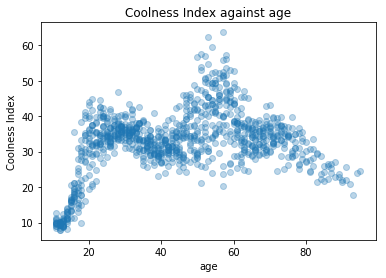

In [26]:
plt.scatter(data.Age,data.Cool,alpha=0.3)
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [27]:
#b

In [28]:
data["G1"]=np.where((data.Age>=11) & (data.Age<22),1,0)
data["G2"]=np.where((data.Age>=22) & (data.Age<40),1,0)
data["G3"]=np.where((data.Age>=40) & (data.Age<59),1,0)
data["G4"]=np.where((data.Age>=59) & (data.Age<77),1,0)
data["G5"]=np.where((data.Age>=77) & (data.Age<=95),1,0)

In [30]:
X = data[["G1","G2","G3","G4","G5"]]
res2 = sm.OLS(data.Cool,X).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 24 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        14:54:37   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1            20.1025      0.562     35.746      0.0

The estimated step function values for each bin are 20.1025, 34.4758, 37.6351, 35.2254 and 27.2964.

In [31]:
res2.predict([0,0,0,1,0])

array([35.22540004])

The predicted coolness of a 73-year old from the stepwise function is 35.23.

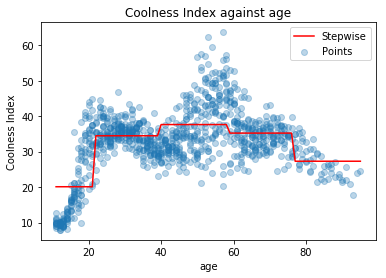

In [33]:
plt.scatter(data.Age,data.Cool,alpha = 0.3,label = "Points")
plt.plot(data.Age,res2.predict(),"r",label = "Stepwise")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [ ]:
#c

In [35]:
data1 = data.groupby('Age').mean()
data1['Age']=data1.index
data1.describe()

,Cool,G1,G2,G3,G4,G5,Age
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,31.362671,0.129412,0.211765,0.223529,0.211765,0.223529,53.000000
std,7.656243,0.337647,0.410984,0.419083,0.410984,0.419083,24.681302
min,9.365623,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
25%,26.834505,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
50%,33.061441,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000
75%,35.700172,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000
max,46.709240,1.000000,1.000000,1.000000,1.000000,1.000000,95.000000


In [37]:
knots = [22,40,59,77]
lins = LSQUnivariateSpline(np.array(data1.Age), np.array(data1.Cool), t=knots, k=1)

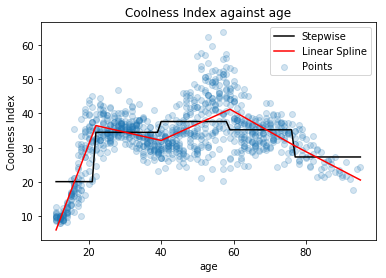

In [42]:
plt.scatter(data.Age,data.Cool,alpha=0.2,label="Points")
plt.plot(data.Age,res2.predict(),"k",label = "Stepwise")
plt.plot(data1.Age,lins(data1.Age),"r",label = "Linear Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [43]:
lins(73)

array(32.86784862)

The predicted coolness of a 73-year old from the linear spline is 32.87.

In [44]:
#d

In [45]:
cubs = LSQUnivariateSpline(np.array(data1.Age), np.array(data1.Cool), t=knots, k=3)

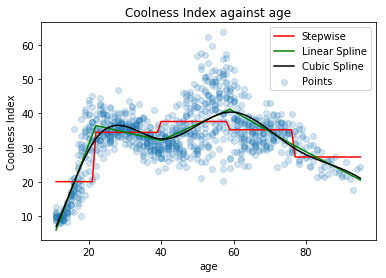

In [47]:
plt.scatter(data.Age,data.Cool,alpha=0.2,label="Points")
plt.plot(data.Age,res2.predict(),"r",label = "Stepwise")
plt.plot(data1.Age,lins(data1.Age),"g",label = "Linear Spline")
plt.plot(data1.Age,cubs(data1.Age),"k",label = "Cubic Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [48]:
cubs(73)

array(32.64230107)

The predicted coolness of a 73-year old from the cubic spline is 32.64.